<a href="https://colab.research.google.com/github/olga1590/Object_detection/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection with TF-Hub

In [2]:
# Mandatory imports
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# We'll use requests and PIL to download and process images
import requests
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

In [3]:
# Function for load images from URL

def load_image(image_url):
    img = Image.open(requests.get(image_url, stream=True).raw)
    return img

In [4]:
# Resize image

def resize_image(img):
    # Resize image to be no larger than 1024x1024 pixels while retaining 
    # the image's aspect ratio
    maxsize = (1024, 1024)
    img.thumbnail(maxsize, Image.ANTIALIAS)
    return img

In [9]:
# Load model from TensorFlow Hub

module_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_url).signatures['default']

In [16]:
# Define image URL

IMAGE_URL = "https://cdn.shrm.org/image/upload/c_crop,h_408,w_724,x_0,y_75/c_fit,f_auto,q_auto,w_767/v1/Benefits/office_space_kj3wup?databtoa=eyIxNng5Ijp7IngiOjAsInkiOjc1LCJ4MiI6NzI0LCJ5MiI6NDgzLCJ3Ijo3MjQsImgiOjQwOH19"

img = load_image(IMAGE_URL)
img = resize_image(img)

In [6]:
numpy_img = np.asarray(img)
print(numpy_img.shape)

(379, 1024, 3)


In [7]:
# Convert and normalize image

converted_img  = tf.image.convert_image_dtype(img, tf.float32)
scaled_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

In [10]:
output = detector(scaled_img)

In [20]:
for obj, confidence in list(zip(output['detection_class_entities'], output['detection_scores']))[:10]:
 print("Detected {} with {:.2f}% confidence".format(obj, confidence))

Detected b'Office building' with 0.96% confidence
Detected b'Person' with 0.83% confidence
Detected b'Person' with 0.80% confidence
Detected b'Houseplant' with 0.75% confidence
Detected b'Flowerpot' with 0.75% confidence
Detected b'Person' with 0.63% confidence
Detected b'Desk' with 0.61% confidence
Detected b'Table' with 0.60% confidence
Detected b'Office building' with 0.48% confidence
Detected b'Chair' with 0.47% confidence


In [13]:
# Function for drawing boxes

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [14]:
# Function for bounding box on image

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

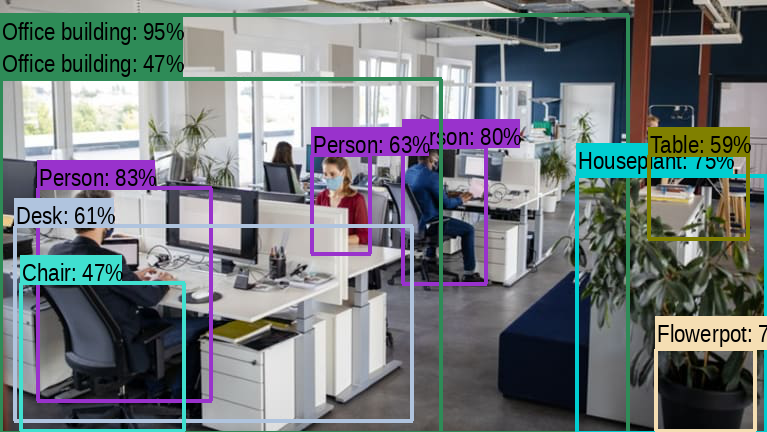

In [34]:
# Draw the boxes
img = draw_boxes(np.array(img), output["detection_boxes"], output["detection_class_entities"].numpy(), output["detection_scores"])

# Convert the image back into PIL.Image so we can display it
img = Image.fromarray(img)

img

In [24]:
# Try to test another image

IMAGE_URL = "https://www.cambridgema.gov/Departments/CommunityDevelopment/%2F-%2Fmedia%2FImages%2FCDD%2FPlanning%2Fcambridgestreetplanning%2Finmandining_kyleklein_kk4_2351_hdr.jpg"

img = load_image(IMAGE_URL)
img = resize_image(img)

In [25]:
numpy_img = np.asarray(img)
print(numpy_img.shape)

# Convert and normalize image

converted_img  = tf.image.convert_image_dtype(img, tf.float32)
scaled_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

output = detector(scaled_img)

(722, 1024, 3)


In [26]:
for obj, confidence in list(zip(output['detection_class_entities'], output['detection_scores']))[:10]:
 print("Detected {} with {:.2f}% confidence".format(obj, confidence))

Detected b'Bicycle' with 0.95% confidence
Detected b'Tree' with 0.79% confidence
Detected b'Tree' with 0.77% confidence
Detected b'Bicycle wheel' with 0.60% confidence
Detected b'Building' with 0.58% confidence
Detected b'Bicycle wheel' with 0.54% confidence
Detected b'Person' with 0.51% confidence
Detected b'Tree' with 0.49% confidence
Detected b'Person' with 0.48% confidence
Detected b'Person' with 0.46% confidence


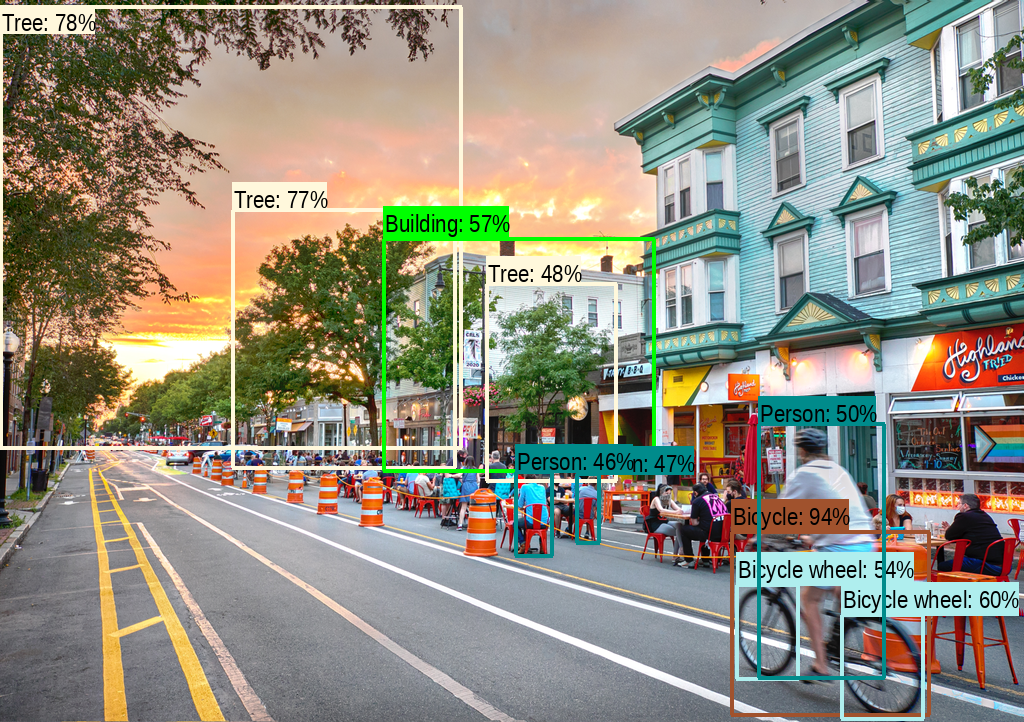

In [27]:
# Draw the boxes
img = draw_boxes(np.array(img), output["detection_boxes"], output["detection_class_entities"].numpy(), output["detection_scores"])

# Convert the image back into PIL.Image so we can display it
img = Image.fromarray(img)

img